## 3 线性神经网络

### 3.1 线性回归

问题定义：

$$
\hat{y} = \mathbf{w}^\top \mathbf{x} + b
$$

损失函数：

$$
l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2
$$

$$
\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b)
$$

解析解：

$$
\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}
$$



本书中我们用到一种名为梯度下降（gradient descent）的方法， 这种方法几乎可以优化所有深度学习模型。 它通过不断地在损失函数递减的方向上更新参数来降低误差。

梯度下降最简单的用法是计算损失函数（数据集中所有样本的损失均值）关于模型参数的导数（在这里也可以称为梯度）。但实际中的执行可能会非常慢：因为在每一次更新参数之前，我们必须遍历整个数据集。 因此，我们通常会在每次需要计算更新的时候随机抽取一小批样本， 这种变体叫做小批量随机梯度下降（minibatch stochastic gradient descent）。

在每次迭代中，我们首先随机抽样一个小批量$\Beta$， 它是由固定数量的训练样本组成的。 然后，我们计算小批量的平均损失关于模型参数的导数（也可以称为梯度）。 最后，我们将梯度乘以一个预先确定的正数 $\eta$，并从当前参数的值中减掉。

$$
(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)
$$

总结一下，算法的步骤如下：

1. 初始化模型参数的值，如随机初始化； 
2. 从数据集中随机抽取小批量样本且在负梯度的方向上更新参数，并不断迭代这一步骤。 

对于平方损失和仿射变换，我们可以明确地写成如下形式:

$$
\begin{split}\begin{aligned} \mathbf{w} &\leftarrow \mathbf{w} -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right),\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_b l^{(i)}(\mathbf{w}, b)  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}\end{split}
$$


#### 3.1.2 矢量化加速

在训练我们的模型时，我们经常希望能够同时处理整个小批量的样本。为了实现这一点，需要我们对计算进行矢量化， 从而利用线性代数库，而不是在Python中编写开销高昂的for循环。


In [2]:
%matplotlib inline
import math
import time
import numpy as np
import torch

In [3]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [4]:
# 定义一个计时器
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [7]:
# 测试for循环
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
print(f'{timer.stop():.5f} sec')

0.09545 sec


In [8]:
# 矩阵重载符号+
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00059 sec'

#### 3.1.3 正态分布与平方损失

接下来，我们通过对噪声分布的假设来解读平方损失目标函数。

正态分布公式：

$$
p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right)
$$

In [9]:
#定义一个函数计算正态分布
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

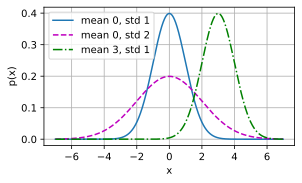

In [10]:
# 再次使用numpy进行可视化
import utils
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
utils.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

均方误差损失函数假设的公式：

$$
y = \mathbf{w}^\top \mathbf{x} + b + \epsilon, \epsilon \sim \mathcal{N}(0, \sigma^2)
$$

因此，我们现在可以写出通过给定的$\mathbf{x}$观测到特定$y$的似然（likelihood）：

$$
P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).
$$

现在，根据极大似然估计法，参数$\mathbf{w}$和$b$的最优值是使整个数据集的似然最大的值：

$$
P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)}|\mathbf{x}^{(i)}).
$$

根据极大似然估计法选择的估计量称为极大似然估计量。 虽然使许多指数函数的乘积最大化看起来很困难， 但是我们可以在不改变目标的前提下，通过最大化似然对数来简化。 由于历史原因，优化通常是说最小化而不是最大化。 我们可以改为最小化负对数似然$-\log P(\mathbf y \mid \mathbf X)$。 由此可以得到的数学公式是：

$$
-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.
$$

In [11]:
### 3.2 线性回归的从零开始实现

In [12]:
%matplotlib inline
import random
import torch

#### 3.2.1 生成数据集

In [14]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.1190, -0.9996]) 
label: tensor([7.3445])


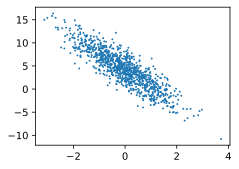

In [15]:
utils.set_figsize()
utils.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);